## Analysis of VirProBERT Embeddings
### Datasets: UniRef90, CoV-S-UniRef90, CoV-S-Uniprot
**Models**: VirProBERT
**Maximum Sequence Length**: segment len 256, stride 64

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/embedding/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/embedding/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/embedding/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/embedding/../..']

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.manifold import TSNE
from src.utils import dataset_utils

/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_embeddings(virprobert_embedding_file_path, id_col, label_col, human_class):
    df = pd.read_csv(virprobert_embedding_file_path, index_col=0)
    print(f"virprobert_embedding_df shape = {df.shape}")
    print(f"Unique labels = {df[label_col].unique()}")

    columns = list(df.columns)
    columns.remove(id_col)
    columns.remove(label_col)
    print(f"Embedding dimension = {len(columns)}")

    train_emb_df, test_emb_df = dataset_utils.split_dataset_stratified(df, seed=79221635, train_proportion=.8, stratify_col=label_col)
    val_emb_df, test_emb_df = dataset_utils.split_dataset_stratified(test_emb_df, seed=79221635, train_proportion=.5, stratify_col=label_col)
    
    train_emb_scaled_df = StandardScaler().fit_transform(train_emb_df[columns])
    test_emb_scaled_df = StandardScaler().fit_transform(test_emb_df[columns])
    
    return train_emb_df, train_emb_scaled_df, test_emb_df, test_emb_scaled_df, columns

In [4]:
def get_umap_emb(train_emb_df, test_emb_df, columns, label_col):
    umap_model = umap.UMAP().fit(train_emb_df[columns])
    umap_emb = umap_model.transform(test_emb_df[columns])
    umap_emb_df = pd.DataFrame(umap_emb, columns=["umap1", "umap2"])
    umap_emb_df[label_col] = test_emb_df.reset_index()[label_col]
    print(f"umap_emb_df shape after adding label col = {umap_emb_df.shape}")
    
    return umap_emb_df

In [5]:
def get_tsne_emb(train_emb_df, test_emb_df, columns, label_col):
    tsne_model = TSNE(init="pca").fit(train_emb_df[columns])
    tsne_emb = tsne_model.fit_transform(test_emb_df[columns])
    tsne_emb_df = pd.DataFrame(tsne_emb, columns=["tsne1", "tsne2"])
    tsne_emb_df[label_col] = test_emb_df.reset_index()[label_col]
    print(f"tsne_emb_df shape after adding label col = {tsne_emb_df.shape}")

    return tsne_emb_df

In [6]:
def plot_emb(embedding_df, x, y, columns, label_col, human_class, human_class_alpha):
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams.update({'font.size': 12})
    
    color_palette = sns.cubehelix_palette(start=1, rot=5.5, hue=1, gamma=1, dark=0.3, light=0.5, reverse=True, n_colors=(embedding_df[label_col].nunique() - 1))
    
    sns.scatterplot(data=embedding_df[embedding_df[label_col] == human_class], x=x, y=y, hue=label_col, ax=ax, alpha=human_class_alpha, palette=[sns.color_palette("rocket_r")[0]])
    sns.scatterplot(data=embedding_df[embedding_df[label_col] != human_class], x=x, y=y, hue=label_col, ax=ax, palette=color_palette)
    ax.legend(bbox_to_anchor=(1.00, 1.01))

### UniRef90 Multiclass Classification

In [7]:
virprobert_embedding_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20241128/host_multi/mlp_embedding/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybd_attn_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-4_output.csv")
label_col = "y_true"
id_col = "uniref90_id"
human_class = "Homo sapiens"

train_emb_df, train_emb_scaled_df, test_emb_df, test_emb_scaled_df, columns = get_embeddings(virprobert_embedding_file_path, id_col, label_col, human_class)

virprobert_embedding_df shape = (31686, 1026)
Unique labels = ['Homo sapiens' 'Marmota himalayana' 'Hydrochoerus hydrochaeris'
 'Sus scrofa' 'Gallus gallus']
Embedding dimension = 1024
Splitting dataset with seed=79221635, train_proportion=0.8, stratify_col=y_true
Size of train_dataset = (25348, 1026)
Size of test_dataset = (6338, 1026)
Splitting dataset with seed=79221635, train_proportion=0.5, stratify_col=y_true
Size of train_dataset = (3169, 1026)
Size of test_dataset = (3169, 1026)


#### UMAP

umap_emb_df shape after adding label col = (25348, 3)


<Figure size 640x480 with 0 Axes>

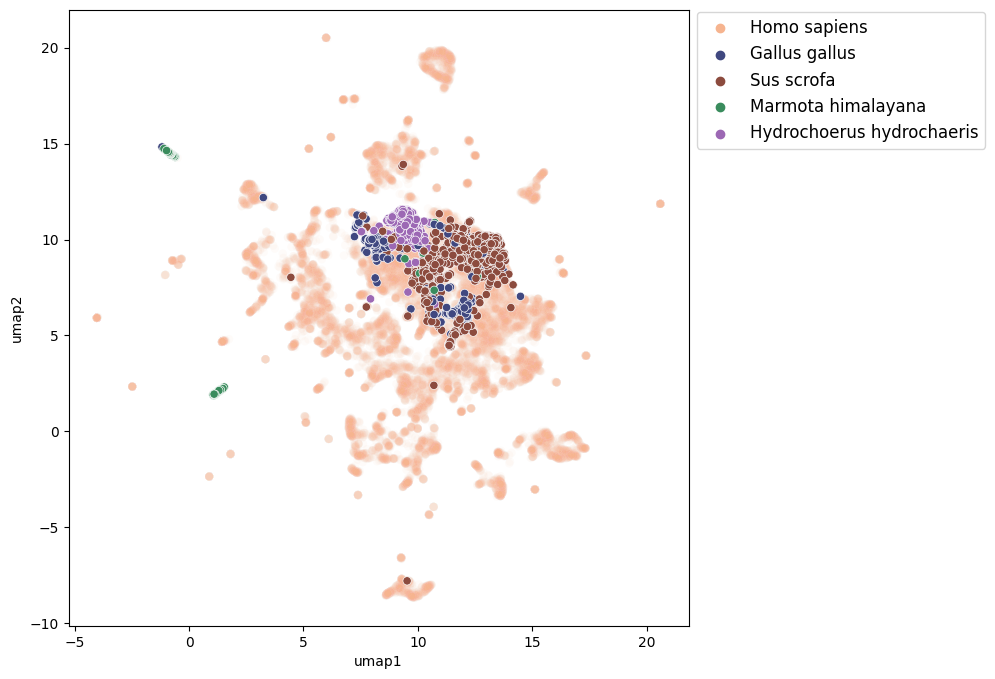

In [8]:
umap_emb_df = get_umap_emb(train_emb_df, train_emb_df, columns, label_col)
plot_emb(umap_emb_df, "umap1", "umap2", columns, label_col, human_class, human_class_alpha=0.05)

### TSNE

tsne_emb_df shape after adding label col = (25348, 3)


<Figure size 640x480 with 0 Axes>

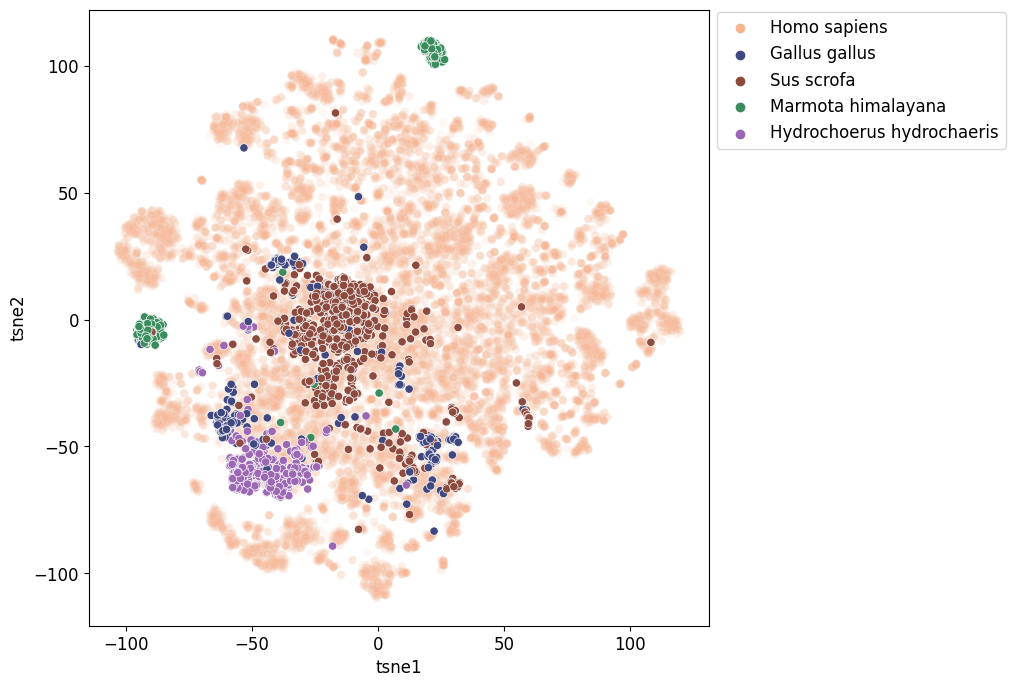

In [9]:
tsne_emb_df = get_tsne_emb(train_emb_df, train_emb_df, columns, label_col)
plot_emb(tsne_emb_df, "tsne1", "tsne2", columns, label_col, human_class, human_class_alpha=0.1)

### CoV-S UniRef90

In [10]:
virprobert_embedding_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241128/host_multi/mlp_embedding/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybd_attn_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-4_output.csv")
label_col = "y_true"
id_col = "uniref90_id"
human_class = "homo sapiens"

train_emb_df, train_emb_scaled_df, test_emb_df, test_emb_scaled_df, columns = get_embeddings(virprobert_embedding_file_path, id_col, label_col, human_class)

virprobert_embedding_df shape = (681, 1026)
Unique labels = ['homo sapiens' 'gallus gallus' 'sus scrofa' 'felis catus'
 'rhinolophus sinicus' 'mustela putorius' 'canis lupus' 'rhinolophus sp.']
Embedding dimension = 1024
Splitting dataset with seed=79221635, train_proportion=0.8, stratify_col=y_true
Size of train_dataset = (544, 1026)
Size of test_dataset = (137, 1026)
Splitting dataset with seed=79221635, train_proportion=0.5, stratify_col=y_true
Size of train_dataset = (68, 1026)
Size of test_dataset = (69, 1026)


In [11]:
test_emb_df

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,uniref90_id,y_true
2,-0.406610,-0.613255,-0.513022,-0.712514,-0.663940,-0.182149,0.069536,1.495016,-0.586354,1.120241,...,-0.884539,-0.614117,-0.636894,1.350505,1.104342,0.295672,-0.017316,-0.744684,['UniRef90_A0A8B1JPN3'],homo sapiens
454,-0.543587,-0.613255,-0.684226,-0.712514,-0.663940,0.204418,-0.605487,0.794348,-0.586354,1.187893,...,-0.884539,-0.614117,-0.181757,-0.047068,-0.219341,0.604386,0.818296,1.138614,['UniRef90_A0A8B6RKC6'],homo sapiens
620,-0.762786,-0.613255,1.036487,0.042062,-0.663940,1.854788,-0.605487,-0.068323,-0.586354,0.221337,...,-0.884539,-0.062833,-0.636894,1.935739,-0.740156,1.284452,-0.711416,-0.744684,['UniRef90_A0A2P1G6K6'],rhinolophus sp.
503,-0.762786,0.323350,-0.254342,0.988853,0.452439,-0.866787,-0.605487,-0.734776,-0.096442,-0.834582,...,1.478982,-0.304126,0.632557,-0.932041,-0.740156,-0.696392,-0.711416,-0.744684,['UniRef90_L7VPD6'],gallus gallus
572,-0.762786,-0.613255,1.722322,0.714783,0.415290,2.398771,-0.605487,-0.734776,-0.586354,-0.834582,...,-0.884539,-0.481760,0.443147,0.058114,-0.740156,-0.567372,-0.711416,-0.744684,['UniRef90_E9LS16'],gallus gallus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,-0.762786,4.004468,-0.684226,2.443161,-0.663940,-0.866787,3.768042,-0.597649,-0.586354,-0.834582,...,0.222039,-0.451313,0.929586,-0.932041,2.938795,-0.696392,-0.711416,3.310662,['UniRef90_A0A6M5WNI4'],felis catus
369,-0.430724,-0.613255,-0.684226,-0.712514,-0.663940,0.235888,-0.605487,0.733673,-0.586354,1.396474,...,-0.884539,-0.613825,-0.229854,0.008640,-0.042336,0.672865,0.739699,1.191688,['UniRef90_A0A8B6RKY6'],homo sapiens
548,4.041830,-0.445079,-0.684226,-0.712514,-0.663940,-0.866787,-0.605487,1.167261,-0.586354,-0.834582,...,2.110270,-0.614117,-0.636894,-0.932041,-0.046840,3.092958,-0.455975,-0.744684,['UniRef90_A0A6H2U1N9'],canis lupus
351,-0.130776,-0.613255,2.054486,-0.712514,0.885435,0.076738,-0.605487,-0.734776,0.124512,-0.512718,...,-0.370797,-0.614117,-0.636894,0.753021,-0.740156,-0.696392,-0.680070,0.199957,['UniRef90_M9YPU0'],gallus gallus


#### UMAP

umap_emb_df shape after adding label col = (544, 3)


<Figure size 640x480 with 0 Axes>

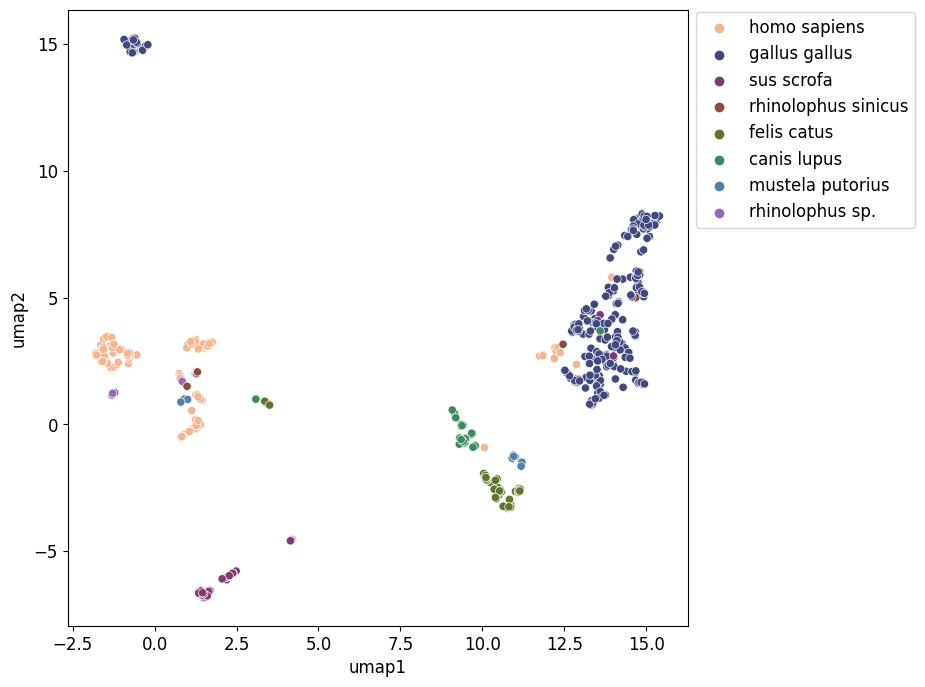

In [12]:
umap_emb_df = get_umap_emb(train_emb_df, train_emb_df, columns, label_col)
plot_emb(umap_emb_df, "umap1", "umap2", columns, label_col, human_class, human_class_alpha=1)

#### TSNE

tsne_emb_df shape after adding label col = (544, 3)


<Figure size 640x480 with 0 Axes>

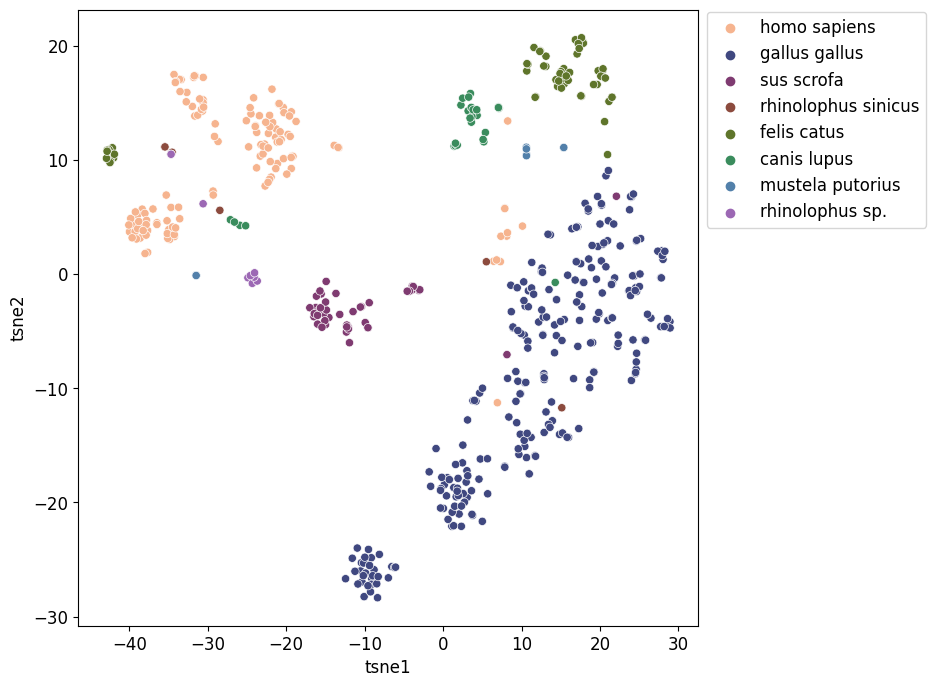

In [13]:
tsne_emb_df = get_tsne_emb(train_emb_df, train_emb_df, columns, label_col)
plot_emb(tsne_emb_df, "tsne1", "tsne2", columns, label_col, human_class, human_class_alpha=1)

### CoV-S UniProt

In [14]:
virprobert_embedding_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241128/host_multi/mlp_embedding/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybd_attn_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-5_output.csv")
label_col = "y_true"
id_col = "uniprot_id"
human_class = "homo sapiens"

train_emb_df, train_emb_scaled_df, test_emb_df, test_emb_scaled_df, columns = get_embeddings(virprobert_embedding_file_path, id_col, label_col, human_class)

virprobert_embedding_df shape = (3567, 1026)
Unique labels = ['sus scrofa' 'homo sapiens' 'gallus gallus' 'camelus dromedarius'
 'bos taurus' 'canis lupus' 'bos grunniens' 'felis catus']
Embedding dimension = 1024
Splitting dataset with seed=79221635, train_proportion=0.8, stratify_col=y_true
Size of train_dataset = (2853, 1026)
Size of test_dataset = (714, 1026)
Splitting dataset with seed=79221635, train_proportion=0.5, stratify_col=y_true
Size of train_dataset = (357, 1026)
Size of test_dataset = (357, 1026)


#### UMAP

umap_emb_df shape after adding label col = (2853, 3)


<Figure size 640x480 with 0 Axes>

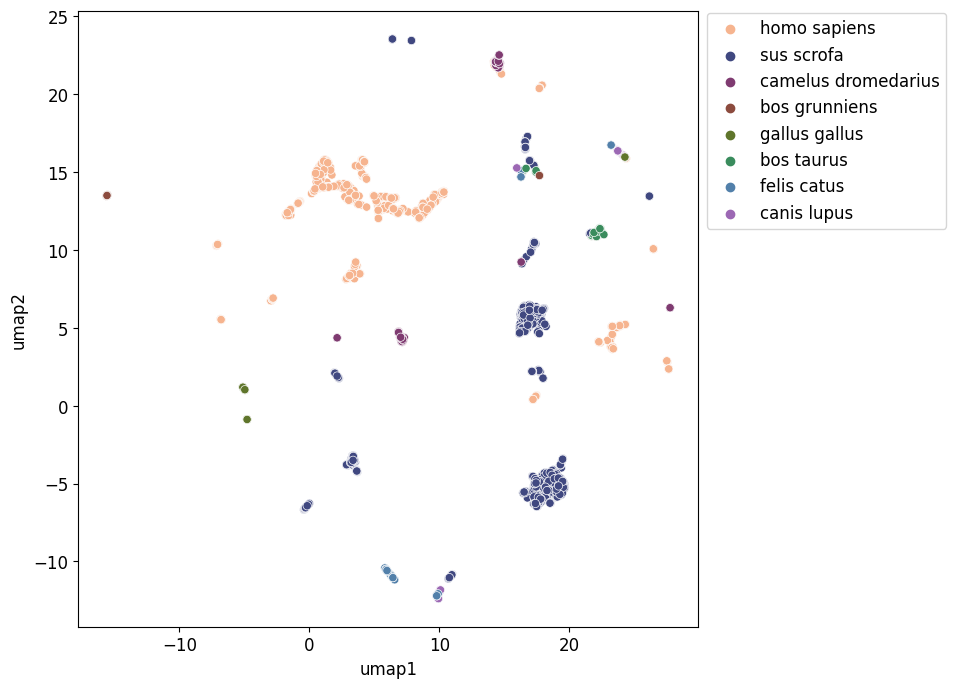

In [15]:
umap_emb_df = get_umap_emb(train_emb_df, train_emb_df, columns, label_col)
plot_emb(umap_emb_df, "umap1", "umap2", columns, label_col, human_class, human_class_alpha=1)

#### TSNE

tsne_emb_df shape after adding label col = (2853, 3)


<Figure size 640x480 with 0 Axes>

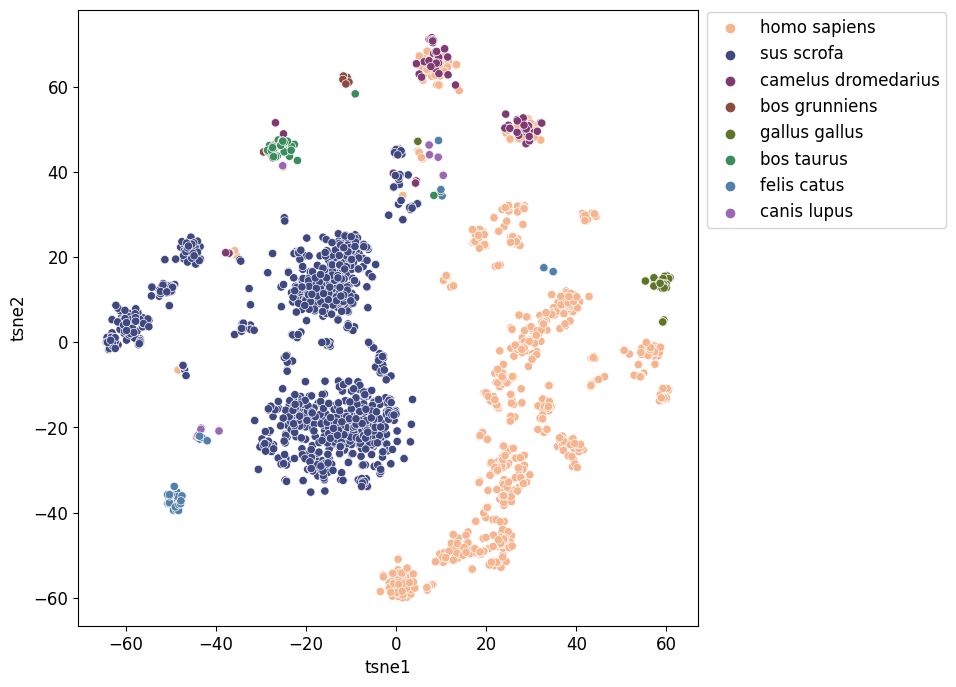

In [16]:
tsne_emb_df = get_tsne_emb(train_emb_df, train_emb_df, columns, label_col)
plot_emb(tsne_emb_df, "tsne1", "tsne2", columns, label_col, human_class, human_class_alpha=1)